In [1]:
import os
project_root = os.pardir
import sys
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

import random as rand
import networkx as nx
import data.make_dataset as dat
import collections as col
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
class LFN:
    '''
    Class of Labour Flow Networks.

    - Inherit from the class of networkx networks.
    - Make method: Create an LFN for the years specified
    - FilepathInfo method: return a string to be used as part of a filename
    specifying the key details of the LFN

    Node Attributes:
        'Dead': dictionary mapping every node to True if node is dead or False
        if node is alive.
        
    Data Attributes
        dead_nodes: set of dead nodes.
    '''
    def __init__(
                self,
                flow_years, nflow_rows=None,
                death_years=None, ndeath_rows=None
                ):
        '''
        Create LFN from specified flowyears and add corresponding filepath info.
        If deathyears provided add dead_ids and dead_nodes data attributes
        and mark dead nodes in graph as dead.
        '''

        self.graph = dat.MakeLFN(flow_years, nrows=nflow_rows)
        self.filepath_info = 'flows' + flow_years
        self.AllAlive()
        self.dead_ids = set()
        self.dead_nodes = set()
        if death_years != None:
            self.filepath_info = self.filepath_info + '_deaths' + death_years
            self.dead_ids = dat.GetDeadIds(
                                    death_years=death_years, nrows=ndeath_rows
                                    )
            self.dead_nodes = set(dat.DeadInLFN(self.graph, self.dead_ids))
            self.KillNodes(self.dead_nodes)

    def PrintInfo(self):
        '''
        Print info on LFN.
        '''
        nx.info(self.graph)
        print('Death Years: ' + death_years)

    def AllAlive(self):
        '''
        Sets node attributes so that all nodes are marked as alive.
        '''
        dead_dict = dict()
        for node in self.graph.nodes():
            dead_dict[node] = False
        nx.set_node_attributes(self.graph, 'Dead', dead_dict)

    def KillNodes(self, dead_ids):
        '''
        Change node attributes for nodes in list dead_ids to Dead.
        Also updates the 'dead_nodes' list.
        '''
        dead_nodes = dat.DeadInLFN(self.graph, dead_ids)
        new_dead_nodes = set(dead_nodes).difference(self.dead_nodes)
        #update attributes
        dead_dict = nx.get_node_attributes(self.graph, 'Dead')
        for node in new_dead_nodes:
            dead_dict[node] = True
        nx.set_node_attributes(self.graph, 'Dead', dead_dict)
        #add new dead nodes to list of dead nodes
        self.dead_nodes = self.dead_nodes.union(set(new_dead_nodes))
        self.dead_ids = self.dead_ids.union(set(dead_ids))
        
    def AliveNodes(self):
        '''
        Return set of nodes in LFN that are alive.
        '''
        return set(self.graph.nodes()).difference(self.dead_nodes)
    
    def NodeDead(self, node):
        '''
        Return True if node is dead and False if node is alive.
        '''
        return self.graph.node[node]['Dead']
    
    def UpdatedDegree(self, node):
        '''
        Return the updated degree of the node. That means it is
        number of neighbours of the node that are alive.
        '''
        neighs = nx.neighbors(self.graph, node)
        alive_neighs = [neigh for neigh in neighs if not self.NodeDead(neigh)]
        return len(alive_neighs)

In [9]:
def PropDead(all_count, dead_count):
    '''
    Take dictionary of dead counts and compare it to dictionary of counts for
    the entire LFN by taking ratios.
    'Overall' is the overall proportion of firms that died.
    Return dictionary of proportion dead.
    '''
    prop_dead = dict()
    for key in all_count.keys():
        prop_dead[key] = dead_count[key]/float(all_count[key])
    prop_dead['Overall'] = sum(dead_count.values())/float(sum(all_count.values()))
    return prop_dead

def UpdatedDegreeRun(year1, yearend, lfn, mc=False):
    '''
    Carry out one run for to get updated degrees of all dead nodes and
    all nodes. Updated degree is degree of node in LFN minus the number
    of dead neighbours of the node (ie, number of living neighbours).
    
    More precisely, this function takes the first one year interval
    'year1-year1+1' and makes a list of the updated degree of every node in
    the LFN (since this is the first year, the updated degree is actually
    the same as the degree). It then finds the firms that died in the interval
    'year1-year1+1' and produces a list of the updated degrees of all these
    firms. The next year is then considered, 'year1+1-year1+2' and the updated
    degrees of all remaining firms are added to the list of all degrees and
    similarly the updated degrees of all firms that died in that year are added
    to the list of all dead degrees.
    
    Note that:
        (a) In the calculation of the updated degree of node i, nodes that
        died in the same year as node i are counted as alive.
        (b) The function returns only returns the running total of the updated
        degrees of all the firms that died in the entire 'year1-yearend' interval.
    
    Args
    =====
    year1 : int
        The first year of deaths to be considered.
    yearend : int
        The last year of deaths to be considered.
    lfn : LFN
        The lfn object being considered
    mc : bool
        Specifies whether a Monte Carlo Run is desired. In a Monte Carlo run
        the number of deaths in each interval of years is found from the data,
        but the firm IDs of the dead firms are chosen at random.
    
    Returns
    =======
    2 lists : all_updtdeg, dead_updtdeg
    dead_uptdeg is a list of the updated degrees of every firm that
    died, where the updated degree is calculated at the time of death. all_updtdeg
    is a list of the updated degrees of every firm at the end of each time period.
    
    These lists can be used to find, eg, the proportion of all firms with a given
    updated degree that died.
    '''
    lfn.AllAlive()
    dead_updtdeg = []
    all_updtdeg = []
    for year in range(year1, yearend):
        death_years = dat.StrFromYrs(year, year+1)
        dead_ids = dat.GetDeadIds(death_years = death_years)
        dead_nodes = dat.DeadInLFN(lfn.graph, dead_ids)
        if mc==True: #if Monte Carlo run then randomise dead nodes
            number_dead_nodes = len(dead_nodes)
            all_nodes = lfn.graph.nodes()
            rand.shuffle(all_nodes)
            dead_nodes = all_nodes[:number_dead_nodes]
        dead_updtdeg += [lfn.UpdatedDegree(node) for node in dead_nodes]
        all_updtdeg += [lfn.UpdatedDegree(node) for node in lfn.graph.nodes()]
        lfn.KillNodes(dead_ids)
    return all_updtdeg, dead_updtdeg

In [57]:
lfn = LFN('1996-1997')
year1, yearend = 1996, 1998
number_mc_runs = 2
act_all_updtdeg, act_dead_uptdeg = UpdatedDegreeRun(year1, yearend, lfn)
mc_res = []
for i in range(number_mc_runs):
    mc_res += [UpdatedDegreeRun(year1, yearend, lfn, mc=True)]

Name: LFN with flows: 1996-1997.
Type: Graph
Number of nodes: 31661
Number of edges: 37233
Average degree:   2.3520


In [58]:
act_all_count = col.Counter(act_all_updtdeg)
act_dead_count = col.Counter(act_dead_uptdeg)
act_prop_dead = PropDead(act_all_count, act_dead_count)
#create empty list of monte carlo proportion dead dicts
mc_prop_deads = []
for run in mc_res:
    mc_all_count = col.Counter(run[0])
    mc_dead_count = col.Counter(run[1])
    mc_prop_deads += [PropDead(mc_all_count, mc_dead_count)]

In [85]:
mcavg_prop_dead = dict()
for updtdeg in mc_prop_deads[0].keys():
    updtdegs = [pd[updtdeg] for pd in mc_prop_deads]
    avg = sum(updtdegs)/float(len(updtdegs))
    mcavg_prop_dead[updtdeg] = avg

In [61]:
def MonteCarloBoxPlot(monte_carlo, actual, axes, info=None, xpos=1):
    '''
    Plot monte carlo results as box and whiskers plot with actual
    result superimposed.
    
    Args
    =====
    monte_carlo : list of scalars
        List of the results of each monte carlo run
    actual : scalar
        Actual result.
    info : string
        Specifies what the plot is showing.
    xpos : scalar
        Specifies the position on the x-axis of the plot.
        
    Returns
    =======
    Boxplot
    '''
    axes.boxplot( monte_carlo,
                showcaps=False,
                #boxprops=dict(facecolor = 'red', linewidth=0, alpha = 0.8),
                medianprops=dict(color='w'),
                showfliers=False,
                whiskerprops=dict(color='k', alpha=0.5, linestyle='-'),
                positions=[xpos]
                )
    axes.scatter([xpos], [actual], color='gray', marker = 'D', s = 10, linewidth=2,)

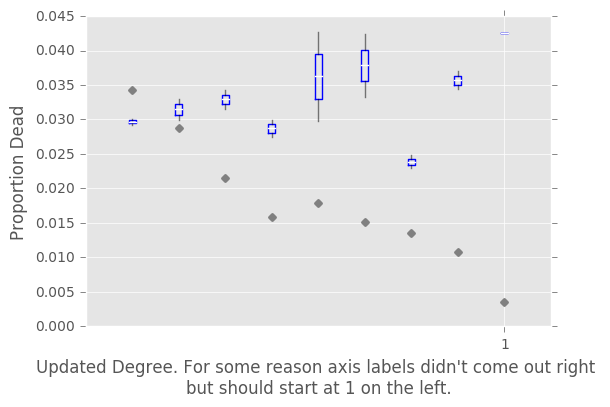

In [97]:
fig = plt.figure() #create figure
ax = fig.add_subplot(1,1,1) #add axes
updtdegs = range(1, 10)
for updtdeg in updtdegs:
    monte_carlo = [prop_dead[updtdeg] for prop_dead in mc_prop_deads]
    actual = act_prop_dead[updtdeg]
    MonteCarloBoxPlot(monte_carlo, actual, ax, info=str(updtdeg), xpos=updtdeg)
ax.set_xlim(min(updtdegs)-1, max(updtdegs)+1)
ax.set_xticklabels(updtdegs)
ax.set_xlabel('Updated Degree. For some reason axis labels didn\'t come out right \n' \
                 'but should start at 1 on the left.')
ax.set_ylabel('Proportion Dead')
plt.savefig(os.path.join(
                        project_root, 'reports', 'figures',
                        'updated_degree_boxplots.png'))

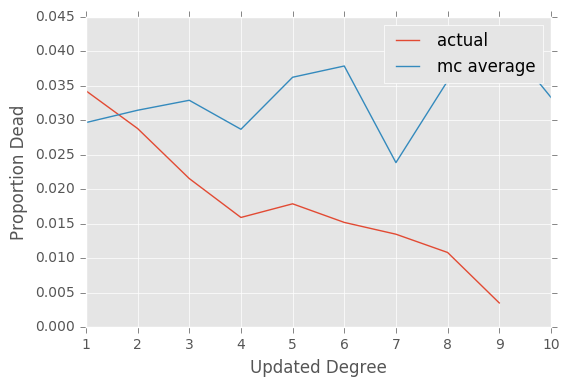

In [99]:
s=1
l=10
plt.plot(act_prop_dead.keys()[s:l], act_prop_dead.values()[s:l], label='actual')
plt.plot(mcavg_prop_dead.keys()[s-1:l], mcavg_prop_dead.values()[s-1:l], label= 'mc average')
plt.xlabel('Updated Degree')
plt.ylabel('Proportion Dead')
plt.legend()
plt.savefig(os.path.join(
                        project_root, 'reports', 'figures',
                        'updated_degree_average.png'))

In [ ]:
#compare Monte Carlo to actual results
fvs = [1, 2, 3, 4, 5] #values of the feature we want to plot
fig, axarr = plt.subplots(1, len(fvs), figsize=(10, 5), sharey=True)
ax_num = 0
for fv in fvs:
    #Get the list of proportions of firms with feature value fv
    #that are chosen to be dead in this Monte Carlo run.
    mc_prop_deads_at_fv = [x[fv] for x in mc_prop_deads]
    #Add boxplot of proportions dead in Monte Carlo runs
    axarr[ax_num].boxplot(mc_prop_deads_at_fv, showfliers = False, positions=[fv])
    #Add actual value of proportion dead
    axarr[ax_num].scatter([fv], prop_dead[fv], marker='+', color='g', linewidth=10, label='Actual')
    #Ensure that the next plot is on a new axis
    ax_num += 1
plt.legend()
feature_info = str(feature_function)[10:-16]
plt.title(
            'Box plots showing results of Monte Carlo with green pluses' \
            'representing the actual results. \n All plots showing proportion' \
            'of total firms in LFN dead with given feature value. \n The feature' \
            'here is from the function ' + feature_info,
            loc='right', fontsize=10)
plt.xlabel(feature_info)
plt.ylabel('Proportion Dead')
plt.savefig(os.path.join(
                        project_root, 'reports', 'figures',
                        'effect_of_' + feature_info + '.png'))